1. Introduce the Data

Task: Given attributes about a prson, predict whether he/she will be able to pay loan in furture or not

In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv("credit_train.csv")

# removing unwanted features like LOanID and CustomerID
df = df.drop(df[['Loan ID', 'Customer ID']], axis=1)
df.columns

Index(['Loan Status', 'Current Loan Amount', 'Term', 'Credit Score',
       'Annual Income', 'Years in current job', 'Home Ownership', 'Purpose',
       'Monthly Debt', 'Years of Credit History',
       'Months since last delinquent', 'Number of Open Accounts',
       'Number of Credit Problems', 'Current Credit Balance',
       'Maximum Open Credit', 'Bankruptcies', 'Tax Liens'],
      dtype='object')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100514 entries, 0 to 100513
Data columns (total 17 columns):
Loan Status                     100000 non-null object
Current Loan Amount             100000 non-null float64
Term                            100000 non-null object
Credit Score                    80846 non-null float64
Annual Income                   80846 non-null float64
Years in current job            95778 non-null object
Home Ownership                  100000 non-null object
Purpose                         100000 non-null object
Monthly Debt                    100000 non-null float64
Years of Credit History         100000 non-null float64
Months since last delinquent    46859 non-null float64
Number of Open Accounts         100000 non-null float64
Number of Credit Problems       100000 non-null float64
Current Credit Balance          100000 non-null float64
Maximum Open Credit             99998 non-null float64
Bankruptcies                    99796 non-null float64
Tax 

Take a look at  the outcome variable: Loan Status

In [4]:
print(df['Loan Status'].value_counts())

Fully Paid     77361
Charged Off    22639
Name: Loan Status, dtype: int64


Assign outcome as '0' if Loan is paid and as '1' if Loan is cahrged off

In [5]:
df['Loan Status'] = [0 if x == 'Fully Paid' else 1 for x in  df['Loan Status']]

In [6]:
# removing string data from column to make it float type
mapping_dict = {'8 years': 8, '10+ years': 10, '3 years': 3, '5 years': 5, '< 1 year': 0, '2 years': 2,
                '4 years': 4, '9 years': 9, '7 years': 7, '1 year': 1, '6 years': 6, 'n/a': np.nan}


def f(x):
    try:
        return mapping_dict[x]
    except:
        return x


df['Years in current job'] = df['Years in current job'].apply(f).astype(np.float64)

Defining X & Y for the complete dataset (will be useful for training neural network as 100K samples is a good amount)

In [7]:
#df1 = df.dropna(thresh=16)
#X1 = df1.drop('Loan Status',1)
#Y1 = df1['Loan Status']

In [8]:
#how much of your data is missing
#X1.isnull().sum().sort_values(ascending=False)

In [9]:
#X1.head()

In [10]:
#Impute missing values using Imputer 

#from sklearn.preprocessing import Imputer

#imp = Imputer(missing_values = 'NaN', strategy='median', axis=0)
#imp.fit(X1)
#X1=pd.DataFrame(data=imp.transform(X1), columns=X1.columns)

# Defining X & Y without NAN dataset (will be useful for simpler models like LR, DT, SVM)

In [11]:
df2 = df.dropna(thresh=17)
X2 = df2.drop('Loan Status',1)
Y2 = df2['Loan Status']

In [12]:
X2.shape

(36423, 16)

In [13]:
Y2.shape

(36423,)

2. Basic Data Cleaning

Must convert categorical and ordinal features into numeric features


In [14]:
#Decide which categorical variables you want to use in model

for col_name in X2.columns:
    if X2[col_name].dtypes == 'object':
        unique_cat = len(X2[col_name].unique())
        print("Feature {0} has {1} unique categories".format(col_name, unique_cat))

Feature Term has 2 unique categories
Feature Home Ownership has 4 unique categories
Feature Purpose has 16 unique categories


Let's see how many observations does each category has in Purpose Attribute

In [15]:
print(X2['Purpose'].value_counts().sort_values(ascending=False))

Debt Consolidation      28202
Home Improvements        2409
other                    2313
Other                    1150
Business Loan             596
Medical Bills             444
Buy a Car                 428
Buy House                 263
Take a Trip               219
major_purchase            116
small_business            111
moving                     55
vacation                   41
wedding                    39
Educational Expenses       33
renewable_energy            4
Name: Purpose, dtype: int64


In [16]:
#Most of the categories have a very low frequency, we don't want to create dummies for these. 
#We will add those to others

X2['Purpose'] = ['Debt Consolidation' if x == 'Debt Consolidation' else 'Other' for x in X2['Purpose']]
print(X2['Purpose'].value_counts().sort_values(ascending=False))

Debt Consolidation    28202
Other                  8221
Name: Purpose, dtype: int64


Now, Creating Dummy Features

In [17]:
#create a list of features to dummy

to_dummy_list = ['Term', 'Home Ownership', 'Purpose']

#function to dummy all the categorical variable used for modeling

def dummy_df(df, to_dummy_list):
    for x in to_dummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x,1)
        df = pd.concat([df, dummies], axis=1)
        
    return df

X2 = dummy_df(X2, to_dummy_list)

MORE DATA EXPLORATION : Outlier Detection

In [22]:
def find_outliers_tukey(x):
    q1 = np.percentile(x,25)
    q3 = np.percentile(x,75)
    iqr = q3 -q1
    
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    
    outlier_indices = list(x.index[(x<floor) | (x>ceiling)])
    return outlier_indices

tukey_indices = find_outliers_tukey(X2['Annual Income'])
#X2 = X2.drop(X2.index[tukey_indices])


In [23]:
len(tukey_indices)

1703

In [25]:
max(tukey_indices)

99981

In [ ]:
################ NOT ABLE TO CORRECT THE OUTLIER CODE YET #################################

KernelDensity estimator for outlier detection

Distribution of features : Histograms  broken up by outcome categories (in this case Loan Status)

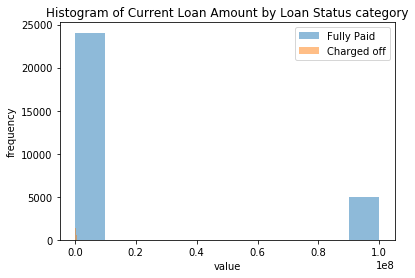

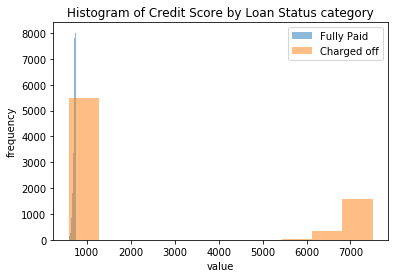

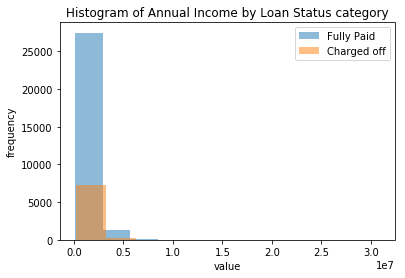

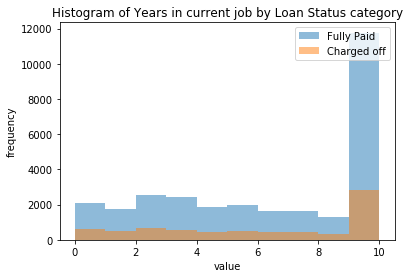

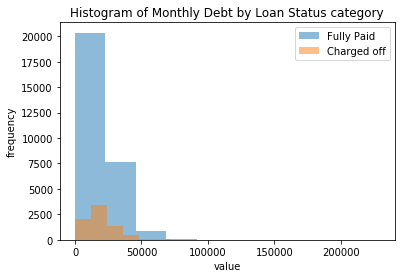

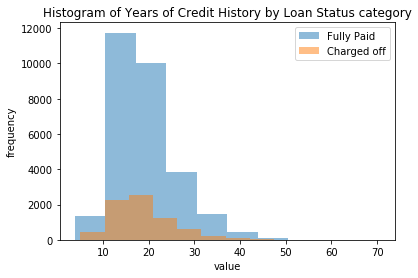

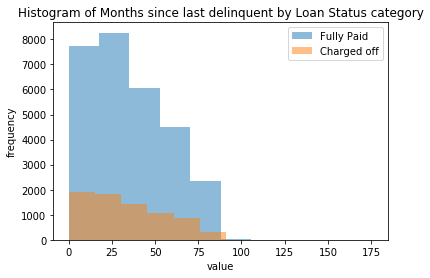

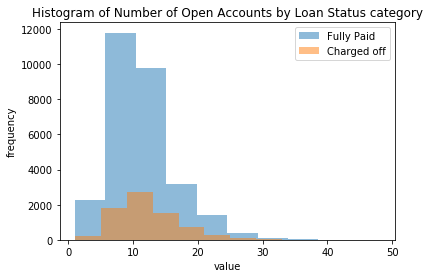

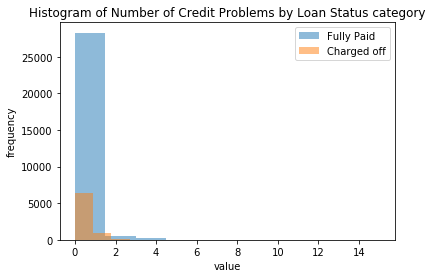

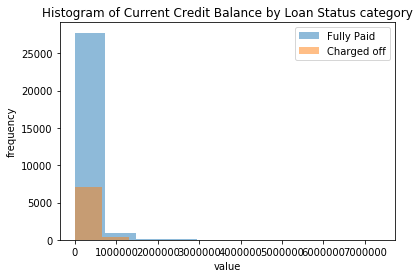

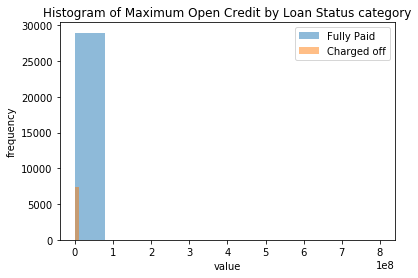

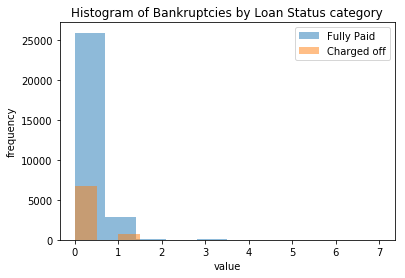

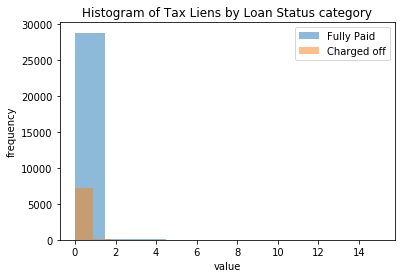

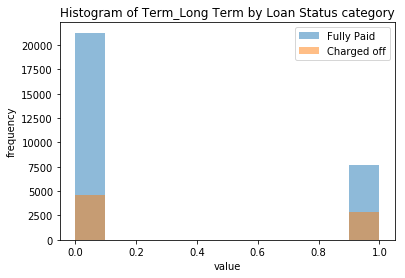

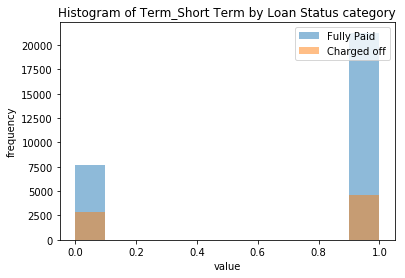

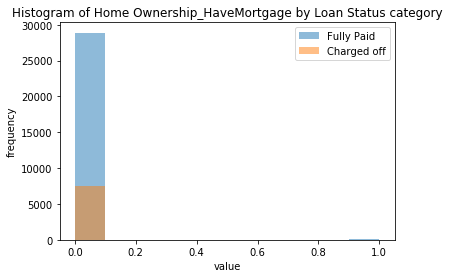

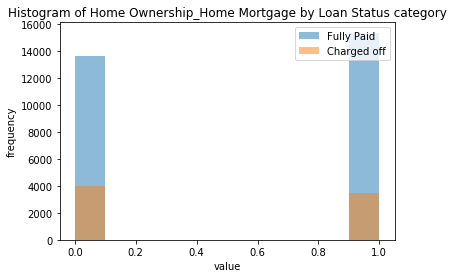

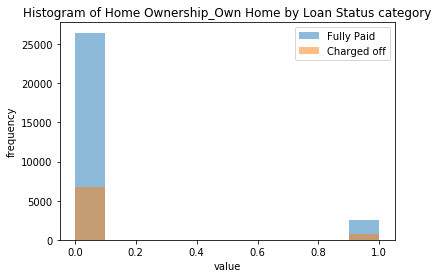

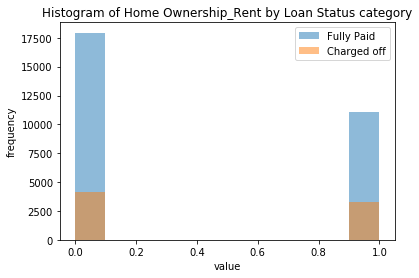

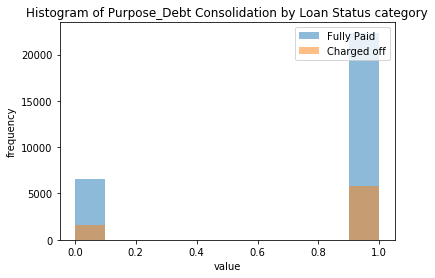

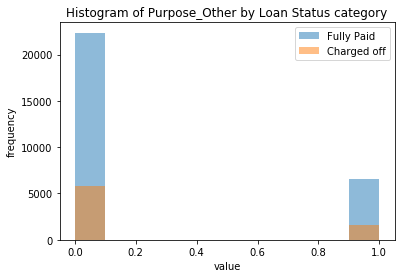

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_histogram(x,y):
    plt.hist(list(x[y==0]), alpha=0.5, label='Fully Paid')
    plt.hist(list(x[y==1]), alpha=0.5, label='Charged off')
    plt.title('Histogram of {0} by Loan Status category'.format(x.name))
    plt.xlabel("value")
    plt.ylabel("frequency")
    plt.legend(loc='upper right')
    plt.show()
    
for x in X2.columns:
    plot_histogram(X2[x],Y2)

In [27]:
X2['Loan Status'] = Y2
X2.shape
#absolute correlation matrix sorted with descending order
corr_abs = abs(X2.corr())
corr_abs[['Loan Status']].sort_values(by='Loan Status',ascending=False)
X2 = X2.drop('Loan Status',1)

In [29]:
def mi(row):
    ai = row["Annual Income"]
    md = row["Monthly Debt"]

    mr = ai / 12 - md
    return mr


def cr(row):
    cla = row["Current Loan Amount"]
    ai = row["Annual Income"]
    return cla / ai

In [30]:
X2["Monthly Income"] = X2.apply(lambda row: mi(row), axis=1)
X2["Credit Ration per Year"]= X2.apply(lambda row: cr(row), axis=1)

In [31]:
X2['Loan Status'] = Y2
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = X2.corr()
corr.style.background_gradient(cmap='coolwarm')

,Current Loan Amount,Credit Score,Annual Income,Years in current job,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Term_Long Term,Term_Short Term,Home Ownership_HaveMortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_Debt Consolidation,Purpose_Other,Monthly Income,Credit Ration per Year,Loan Status
Current Loan Amount,1,-0.0913447,0.0147576,0.00218807,-0.00364193,0.0170558,0.0129383,0.00440516,-0.00214027,0.0090302,-0.000508221,-0.0023619,-0.00356566,-0.0758613,0.0758613,0.00345318,0.0122842,-0.00394989,-0.0106243,0.00866038,-0.00866038,0.0165876,0.87571,-0.200122
Credit Score,-0.0913447,1,-0.0196606,-0.012067,0.00861429,-0.0113693,-0.00332187,0.0130455,-0.00118738,-0.00197398,-0.00388739,-0.00725922,0.00906374,0.0393438,-0.0393438,-0.00154857,-0.0170148,0.00847508,0.0126496,0.0169564,-0.0169564,-0.0227307,-0.0800129,0.467169
Annual Income,0.0147576,-0.0196606,1,0.0646822,0.550253,0.174606,-0.0765988,0.137217,-0.0171614,0.351848,0.0536935,-0.06096,0.0587496,0.0922294,-0.0922294,-0.00019088,0.177675,-0.0384471,-0.159493,-0.0392851,0.0392851,0.990113,-0.11434,-0.059817
Years in current job,0.00218807,-0.012067,0.0646822,1,0.0996422,0.177726,-0.00496896,0.0224399,0.0181431,0.0803888,0.00348348,0.0150849,0.0124028,0.0472897,-0.0472897,0.0147269,0.174327,0.0017617,-0.180883,0.0381134,-0.0381134,0.0532829,-0.025931,-0.0210663
Monthly Debt,-0.00364193,0.00861429,0.550253,0.0996422,1,0.176675,-0.0585308,0.378374,-0.0469572,0.44524,0.0432171,-0.0730979,0.0293558,0.133524,-0.133524,-0.00573279,0.171773,-0.0323961,-0.156409,0.0864685,-0.0864685,0.427688,-0.0991296,0.0163467
Years of Credit History,0.0170558,-0.0113693,0.174606,0.177726,0.176675,1,-0.0438127,0.0992133,0.0204332,0.204668,0.0298065,0.0205193,0.0088779,0.0287581,-0.0287581,0.00207443,0.147115,0.0165932,-0.160377,0.027412,-0.027412,0.15934,-0.0211835,-0.0309382
Months since last delinquent,0.0129383,-0.00332187,-0.0765988,-0.00496896,-0.0585308,-0.0438127,1,-0.0299014,0.103422,-0.0265845,-0.00651691,0.124807,0.0121145,-0.0128581,0.0128581,-0.00123356,-0.0519906,0.000625284,0.0529627,0.0211351,-0.0211351,-0.0730895,0.0246229,-0.0161906
Number of Open Accounts,0.00440516,0.0130455,0.137217,0.0224399,0.378374,0.0992133,-0.0299014,1,-0.0142107,0.225738,0.0320355,-0.0194095,0.000633012,0.0660535,-0.0660535,-0.0161918,0.103636,0.000367624,-0.104646,0.109875,-0.109875,0.0849822,-0.0296202,0.0253608
Number of Credit Problems,-0.00214027,-0.00118738,-0.0171614,0.0181431,-0.0469572,0.0204332,0.103422,-0.0142107,1,-0.111532,-0.0122346,0.702526,0.60221,-0.0255426,0.0255426,0.0083207,-0.0106349,0.00674323,0.00613918,-0.0244422,0.0244422,-0.0106898,0.0065631,0.00590677
Current Credit Balance,0.0090302,-0.00197398,0.351848,0.0803888,0.44524,0.204668,-0.0265845,0.225738,-0.111532,1,0.1663,-0.12231,-0.0164132,0.0957607,-0.0957607,-0.00809898,0.155256,0.00497808,-0.160952,0.0873167,-0.0873167,0.306098,-0.0459256,-0.00853824


In [32]:
X2 = X2.drop('Loan Status',1)

In [34]:
X2.shape

(36423, 23)

Dimensionality Reduction using PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = )
X_pca = pd.DataFrame(pca.fit_transform(X2))

Feature generation Using Feature Tools

Within featuretools there is a standard format for representing data and build features, which is a entity set. A EntitySet stores information about entities (database table), variables (columns in database tables), relationships, and the data itself.

In [45]:
import featuretools as ft

df1 = pd.read_csv("credit_train.csv")
df1 = df1.dropna(thresh=17)

#Most of the categories have a very low frequency, we don't want to create dummies for these. 
#We will add those to others

df1['Purpose'] = ['Debt Consolidation' if x == 'Debt Consolidation' else 'Other' for x in df1['Purpose']]

#create a list of features to dummy

to_dummy_list = ['Term', 'Home Ownership', 'Purpose']

#function to dummy all the categorical variable used for modeling

def dummy_df(df, to_dummy_list):
    for x in to_dummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x,1)
        df = pd.concat([df, dummies], axis=1)
        
    return df

df1 = dummy_df(df1, to_dummy_list)

es = ft.EntitySet("df1")
from featuretools import variable_types as vtypes

es.entity_from_dataframe(entity_id="df1",
                         dataframe=X2)

#Must read for first time users
#es.entity_from_dataframe(entity_id = 'data', dataframe = df, 
                      ### (must add these 2 attributes)   make_index = True, index = 'index')

2019-05-15 03:04:04,418 featuretools.entityset - WARNING    ('Using first column as index. ', 'To change this, specify the index parameter')


Entityset: df1
  Entities:
    df1 [Rows: 36423, Columns: 24]
  Relationships:
    No relationships

Feature Primitives¶
A feature primitive is an operation applied to a table or a set of tables to create a feature. Feature primitives fall into two categories:

Aggregation: function that groups together children for each parent feature and calculates a statistic such as mean, min, max, or standard deviation across the children.

Transformation: an operation applied to one or more columns in a single table.

A list of the available features primitives in featuretools can be viewed below.

In [46]:
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100

primitives[primitives['type'] == 'transform']

,name,type,description
19,time_since,transform,Calculates time since the cutoff time.
20,seconds,transform,Transform a Timedelta feature into the number of seconds.
21,time_since_previous,transform,Compute the time since the previous instance.
22,characters,transform,Return the characters in a given string.
23,is_null,transform,"For each value of base feature, return 'True' if value is null."
24,weekend,transform,Transform Datetime feature into the boolean of Weekend.
25,cum_max,transform,Calculates the max of previous values of an instance for each value in a time-dependent entity.
26,longitude,transform,Returns the second value on the tuple base feature.
27,year,transform,Transform a Datetime feature into the year.
28,second,transform,Transform a Datetime feature into the second.


Deep Feature Synthesis¶ DFS stacks feature primitives to form features with a "depth" equal to the number of primitives.

In [54]:
# use mutiply, add, divide, substract
default_trans_primitives =  ["multiply_numeric","add_numeric", "divide_numeric", "subtract_numeric"]



In [55]:
# DFS with specified primitives
feature_matrix, features = ft.dfs(entityset = es, target_entity = 'df1',
                       trans_primitives = default_trans_primitives,
                       where_primitives = [], seed_features = [],
                       n_jobs = 1, verbose = 1,
                       max_depth = 1, features_only=False)  #set max_depth = 1

ValueError: ('Unknown transform primitive multiply_numeric. ', 'Call ft.primitives.list_primitives() to get', ' a list of available primitives')

In [ ]:
features

In [ ]:
# encode values
fm_encoded, features_encoded = ft.encode_features(feature_matrix,
                                                  features)
fm_encoded.info()

Correlation Check

In [ ]:
df = pd.read_csv("credit_train.csv")
fm_encoded['Loan Staus']=df['Loan Staus']

In [ ]:
#absolute correlation matrix sorted with descending order
corr_abs = abs(fm_encoded.corr())
corr_abs[['Loan Staus']].sort_values(by='Loan Staus',ascending=False)

FEATURE ENGINEERING

In [24]:
from itertools import combinations 
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(3,interaction_only=True)
poly_main = poly.fit_transform(X2)
poly_main_names = poly.get_feature_names(X2.columns)

X2 = pd.DataFrame(data=poly_main, columns=poly_main_names)

#The interactions amongst dummy variables belongiing to the same categorical feature are always zero
#Therefore, we have to remove those empty interaction terms

noint_indices = [i for i, x in enumerate(list((X2 == 0).all())) if x]
X2 = X2.drop(X2.columns[noint_indices], axis=1)

In [25]:
X2.shape

(36423, 1391)

In [26]:
X2['Loan Status'] = Y2
X2.shape

(36423, 1392)

In [ ]:
#absolute correlation matrix sorted with descending order
corr_abs = abs(X2.corr())
corr_abs[['Loan Status']].sort_values(by='Loan Status',ascending=False)

In [27]:
X2 = X2.drop('Loan Status',1)

In [28]:
X2.shape

(36423, 1391)

In [29]:
Y2.shape

(36423,)

In [33]:
X2 = X2.drop('1',1)

FEATURE SELECTION

In [34]:
import sklearn.feature_selection 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X2, Y2, train_size=0.50, random_state=1)

#Such a large set of features may cause over fitting  and also slow computing
#Use feature selection  to select the most importatnt features

select = sklearn.feature_selection.SelectKBest(k=20)
selected_features = select.fit(X_train, y_train)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [X2.columns[i] for i in indices_selected]

X_train_selected = X_train[colnames_selected]
X_test_selected = X_test[colnames_selected]


C:\Users\kanpriya\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [43]:
X_train_selected.columns

Index(['Credit Score', 'Credit Score Annual Income',
       'Credit Score Years in current job', 'Credit Score Monthly Debt',
       'Credit Score Years of Credit History',
       'Credit Score Months since last delinquent',
       'Credit Score Number of Open Accounts',
       'Credit Score Purpose_Debt Consolidation',
       'Credit Score Years in current job Years of Credit History',
       'Credit Score Years in current job Number of Open Accounts',
       'Credit Score Years in current job Purpose_Debt Consolidation',
       'Credit Score Monthly Debt Years of Credit History',
       'Credit Score Monthly Debt Number of Open Accounts',
       'Credit Score Monthly Debt Purpose_Debt Consolidation',
       'Credit Score Years of Credit History Months since last delinquent',
       'Credit Score Years of Credit History Number of Open Accounts',
       'Credit Score Years of Credit History Purpose_Debt Consolidation',
       'Credit Score Months since last delinquent Number of Open Ac

In [36]:
X_train.head()

,Current Loan Amount,Credit Score,Annual Income,Years in current job,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,...,Term_Long Term Home Ownership_Own Home Purpose_Other,Term_Long Term Home Ownership_Rent Purpose_Debt Consolidation,Term_Long Term Home Ownership_Rent Purpose_Other,Term_Short Term Home Ownership_HaveMortgage Purpose_Other,Term_Short Term Home Ownership_Home Mortgage Purpose_Debt Consolidation,Term_Short Term Home Ownership_Home Mortgage Purpose_Other,Term_Short Term Home Ownership_Own Home Purpose_Debt Consolidation,Term_Short Term Home Ownership_Own Home Purpose_Other,Term_Short Term Home Ownership_Rent Purpose_Debt Consolidation,Term_Short Term Home Ownership_Rent Purpose_Other
16595,160006.0,716.0,622839.0,10.0,20761.30,19.4,68.0,9.0,1.0,275177.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
21853,173712.0,723.0,656355.0,3.0,11978.55,12.5,27.0,9.0,0.0,124051.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23473,484616.0,739.0,1379457.0,8.0,28049.13,21.7,64.0,9.0,0.0,5453.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2940,99999999.0,735.0,469452.0,0.0,1275.47,18.1,25.0,5.0,1.0,49096.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
21662,217910.0,730.0,1035082.0,10.0,28205.69,11.0,49.0,22.0,0.0,340556.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [40]:
#manually created 2 new features

#X_train_selected['net_monthly_income'] =  [i/12-j for i in net_monthly_income['Annual Income'] j in net_monthly_income['Monthly Debt']]
#X_train_selected['credit ration'] =  [i/12-j for i in net_monthly_income['Current Loan Amount'] j in net_monthly_income['Annual Income']]

In [41]:
# adding CreditRatio as new feature
def mi(row):
    ai = row["Annual Income"]
    md = row["Monthly Debt"]

    mr = ai / 12 - md
    return mr


def cr(row):
    cla = row["Current Loan Amount"]
    ai = row["Annual Income"]
    return cla / ai

In [44]:
X_train_selected["Monthly Income"] = X2.apply(lambda row: mi(row), axis=1)
X_train_selected["Credit Ration per Year"]= X2.apply(lambda row: cr(row), axis=1)

C:\Users\kanpriya\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\kanpriya\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [45]:
X_train_selected['Loan Status'] = Y2
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = X_train_selected.corr()
corr.style.background_gradient(cmap='coolwarm')

C:\Users\kanpriya\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Credit Score,Credit Score Annual Income,Credit Score Years in current job,Credit Score Monthly Debt,Credit Score Years of Credit History,Credit Score Months since last delinquent,Credit Score Number of Open Accounts,Credit Score Purpose_Debt Consolidation,Credit Score Years in current job Years of Credit History,Credit Score Years in current job Number of Open Accounts,Credit Score Years in current job Purpose_Debt Consolidation,Credit Score Monthly Debt Years of Credit History,Credit Score Monthly Debt Number of Open Accounts,Credit Score Monthly Debt Purpose_Debt Consolidation,Credit Score Years of Credit History Months since last delinquent,Credit Score Years of Credit History Number of Open Accounts,Credit Score Years of Credit History Purpose_Debt Consolidation,Credit Score Months since last delinquent Number of Open Accounts,Credit Score Months since last delinquent Purpose_Debt Consolidation,Credit Score Number of Open Accounts Purpose_Debt Consolidation,Monthly Income,Credit Ration per Year,Loan Status
Credit Score,1,0.706225,0.795348,0.801644,0.914006,0.782903,0.883723,0.851692,0.717316,0.71035,0.695505,0.712989,0.671306,0.703723,0.725944,0.804554,0.785455,0.707946,0.684314,0.767907,-0.0285312,-0.0804677,0.0073547
Credit Score Annual Income,0.706225,1,0.572348,0.751743,0.674425,0.520418,0.663077,0.599869,0.536289,0.538895,0.500476,0.69674,0.666613,0.656572,0.507542,0.628104,0.577668,0.505649,0.456074,0.576019,0.387593,-0.0851627,0.0121002
Credit Score Years in current job,0.795348,0.572348,1,0.662103,0.771841,0.622411,0.692296,0.694498,0.931192,0.89148,0.877468,0.619522,0.544596,0.593266,0.610155,0.66948,0.677267,0.558396,0.554501,0.615823,-0.0080997,-0.0692977,0.00853479
Credit Score Monthly Debt,0.801644,0.751743,0.662103,1,0.764459,0.597218,0.817223,0.708397,0.617673,0.680595,0.598151,0.930451,0.919309,0.884902,0.579924,0.773783,0.675245,0.629037,0.544896,0.721441,0.123466,-0.0890966,0.00341863
Credit Score Years of Credit History,0.914006,0.674425,0.771841,0.764459,1,0.710856,0.821857,0.789512,0.823221,0.701641,0.681874,0.806037,0.649615,0.674354,0.785309,0.890696,0.86795,0.655602,0.629261,0.720068,0.00626841,-0.0764515,0.00454818
Credit Score Months since last delinquent,0.782903,0.520418,0.622411,0.597218,0.710856,1,0.680058,0.685542,0.555152,0.550283,0.556409,0.529096,0.495128,0.542111,0.929568,0.616388,0.627234,0.900602,0.885817,0.608814,-0.0492381,-0.0571942,0.00731543
Credit Score Number of Open Accounts,0.883723,0.663077,0.692296,0.817223,0.821857,0.680058,1,0.775615,0.635804,0.797925,0.623208,0.738455,0.843644,0.724131,0.643066,0.923411,0.723637,0.786905,0.613906,0.878785,-0.0026768,-0.0770146,-0.000623818
Credit Score Purpose_Debt Consolidation,0.851692,0.599869,0.694498,0.708397,0.789512,0.685542,0.775615,1,0.633411,0.638396,0.818643,0.633692,0.599598,0.825704,0.643645,0.712271,0.923506,0.639807,0.803114,0.900144,-0.0382373,-0.0670442,0.00714673
Credit Score Years in current job Years of Credit History,0.717316,0.536289,0.931192,0.617673,0.823221,0.555152,0.635804,0.633411,1,0.84386,0.822489,0.677804,0.515898,0.55358,0.641171,0.722537,0.725056,0.508499,0.498635,0.568941,0.016327,-0.0645656,0.00410367
Credit Score Years in current job Number of Open Accounts,0.71035,0.538895,0.89148,0.680595,0.701641,0.550283,0.797925,0.638396,0.84386,1,0.802525,0.645515,0.697263,0.61622,0.550525,0.780189,0.630107,0.636194,0.504103,0.716589,0.0097107,-0.0669247,0.00410595


In [ ]:
X_train_selected = X_train_selected.drop('Loan Status',1)

#################### SVM ####################

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn import svm as SVM
from sklearn.naive_bayes import GaussianNB as NB
from xgboost import XGBClassifier

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import SGDClassifier

from sklearn.ensemble import VotingClassifier

In [ ]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer

cv = StratifiedKFold(n_splits=10, random_state=42)

1. Tune Hyperparameter of Base Classifiers (without using sampling)

In [ ]:
################################### SVC Linear ##############################################
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import numpy
#param values
penal=["l2"]
losses=["hinge","squared_hinge"]
a=numpy.arange(.0000000001, .0001, .00005)
tolerance=a.tolist()
c_regularization=range(10,3500,10)
intercept_scale=range(1,100,4)
max_iters=range(100,4000,100)
#all param-val dictionary
#grid_params_lr = dict('C':[C_regularization], 'penalty':["l1","l2"], 'intercept_scaling':[ntercept_scal_vals], 'max_iter':[max_iter_vals], 'solver' :["newton-cg", "llbfgs", "sag"])
grid_params_svm = dict(penalty=penal, loss=losses, tol=tolerance, C=c_regularization, max_iter=max_iters)
#creating  grid instance  
#KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2)
svm = LinearSVC(fit_intercept=False)
#neigh_grid=GridSearchCV(knn,grid_params_nn,cv=10)
svm_ins=RandomizedSearchCV(svm,grid_params_svm,cv=10,scoring=f1,n_iter=500)
svm_ins.fit(X_pca, Y2)

In [ ]:
svm_ins.best_estimator_

In [ ]:
svm_ins.best_score_

In [ ]:
##################################### Para tuningfor sklearn.svm.SVC ###########################################
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import numpy
#param values
c_regularization = range(10,1500,10)
kernel_fn = ["linear", "poly", "rbf", "sigmoid"]
power=range(2,7,1)
b=numpy.arange(.0000000001, .001, .00005)
max_iters=range(100,4000,100)
decision_fn = ["ovo", "ovr"]
tolerance=b.tolist()
#all param-val dictionary
#grid_params_lr = dict('C':[C_regularization], 'penalty':["l1","l2"], 'intercept_scaling':[ntercept_scal_vals], 'max_iter':[max_iter_vals], 'solver' :["newton-cg", "llbfgs", "sag"])
grid_params_sv = dict(kernel=kernel_fn, degree=power, decision_function_shape=decision_fn, tol=tolerance, C=c_regularization, max_iter=max_iters)
#creating  grid instance  
#KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2)
sv = SVC()
#neigh_grid=GridSearchCV(knn,grid_params_nn,cv=10)
sv_ins=RandomizedSearchCV(sv,grid_params_sv,cv=10,scoring=f1,n_iter=200)
sv_ins.fit(X_pca, Y2)

In [ ]:
################################# Hyper-Para tuning for XGboost ########################################## 
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy

d=numpy.arange(.05, 5, .05)
lr=d.tolist()
max_dep=[ 3, 4, 5, 6, 8, 10, 12, 15]
min_child_weights=range(1,32,2)
e=numpy.arange(.1, 5, .1)
gammaa=e.tolist()
f=numpy.arange(.1,1,.25)
colsample_bytre=f.tolist()  
    
grid_params_xgb = dict(learning_rate=lr, max_depth=max_dep, min_child_weight=min_child_weights, gamma=gammaa, colsample_bytree=colsample_bytre)
#creating  grid instance  
xgb = XGBClassifier()
xgb_ins=RandomizedSearchCV(xgb,grid_params_xgb,cv=10,scoring=profit_scoring,n_iter=200)
xgb_ins.fit(X_train_prepared, y_train)

In [ ]:
############################### SGD With AdaBoost ###########################
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier

ada=AdaBoostClassifier(base_estimator=SGDClassifier(alpha=7.689254604312759e-05, tol=0.021813007116063123, l1_ratio=0.4260378389709515, random_state=231,penalty='elasticnet', loss='modified_huber'), n_estimators=50, learning_rate=1.0)
sum(cross_validate(ada, X_train_prepared, y=y_train, cv=cv,scoring=f1)['test_score'])

In [ ]:
from sklearn.neural_network import MLPClassifier

def evaluate_classifier1(e_name, e, X_train, y_train, n_folds=10):
        k_fold = StratifiedKFold (n_splits=n_folds, random_state=42)
        scores = cross_val_score(e, X_merge, Y, cv=k_fold, scoring=f1)
        print('Overall cost of {0} is {1}'.format(e_name, scores.mean()))

estimators1 = dict()
estimators1['MLPClassifier']=MLPClassifier(alpha=1); 
for e_name, e in estimators1.items():
    evaluate_classifier1(e_name, e, X2, Y2, 10)